In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.relu = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(23, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1) # Đầu ra 1 cho dự đoán xác suất

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x)
        x = self.fc3(x)

        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
X_train = pd.read_parquet('X_train.parquet')
X_test = pd.read_parquet('X_test.parquet')

X_val = pd.read_parquet('X_val.parquet')
y_val = pd.read_parquet('y_val.parquet')

y_train = pd.read_parquet('y_train.parquet')
y_test = pd.read_parquet('y_test.parquet')

In [6]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6157,1,0,0,0,0.041667,1,0,0,0,0,...,0,0.015920,0.007433,0,1,0,0,0,0,1
817,0,0,1,1,0.763889,1,0,0,1,1,...,1,0.850249,0.651339,1,0,1,0,0,0,0
6977,1,0,0,0,0.333333,1,0,0,1,0,...,1,0.312935,0.140274,0,0,0,0,0,0,1
1932,1,0,0,0,0.013889,1,0,0,0,0,...,0,0.019403,0.002326,0,1,0,0,0,0,1
4168,1,0,1,0,0.847222,0,0,1,0,1,...,1,0.436816,0.435111,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,1,1,0,0,0.166667,0,0,0,0,1,...,1,0.252736,0.060675,0,0,0,0,0,1,0
1409,0,0,1,1,0.597222,1,1,0,0,1,...,1,0.739303,0.465065,1,0,0,0,0,0,0
6834,0,0,0,0,0.208333,0,0,0,1,0,...,1,0.204478,0.069432,0,0,0,1,0,0,1
5685,1,0,1,1,0.625000,1,0,0,0,0,...,0,0.009453,0.104055,0,1,0,1,0,1,0


In [7]:
X_train = X_train.values
X_test = X_test.values

X_val = X_val.values
y_val = y_val.values

y_train = y_train.values
y_test = y_test.values

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [9]:
X_train_tensor

tensor([[1., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [10]:
model = Model().to(device)
# Gọi hàm mất mát BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss()

# Gọi bộ tối ưu Adam với learning rate = 0.0001
optimizer = optim.SGD(model.parameters(), lr=0.0001)

## 1. Với hàm mất mát BCEWithLogitsLoss

### 1.1. Training Test

In [11]:
# Huấn luyện mô hình
epochs = 100
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ huấn luyện
    model.train()

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()

    # Dự đoán
    outputs = model(X_train_tensor)

    # Tính độ mất mát so với kết quả thực
    loss = criterion(outputs, y_train_tensor)

    # Dùng thuật toán Gradient Descent để cập nhật lại trọng số
    loss.backward()
    optimizer.step()

    # In kết quả
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7224
Epoch [20/100], Loss: 0.7221
Epoch [30/100], Loss: 0.7216
Epoch [40/100], Loss: 0.7221
Epoch [50/100], Loss: 0.7220
Epoch [60/100], Loss: 0.7214
Epoch [70/100], Loss: 0.7211
Epoch [80/100], Loss: 0.7218
Epoch [90/100], Loss: 0.7211
Epoch [100/100], Loss: 0.7202


### 1.2. Validation Test

In [12]:
# Huấn luyện mô hình
epochs = 100
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ tập xác thực
    model.eval()

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()

    # Dự đoán
    outputs = model(X_train_tensor)

    # Tính độ mất mát so với kết quả thực
    loss = criterion(outputs, y_train_tensor)

    # Dùng thuật toán Gradient Descent để cập nhật lại trọng số
    loss.backward()
    optimizer.step()

    # In kết quả
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.7208
Epoch [20/100], Loss: 0.7215
Epoch [30/100], Loss: 0.7206
Epoch [40/100], Loss: 0.7208
Epoch [50/100], Loss: 0.7204
Epoch [60/100], Loss: 0.7198
Epoch [70/100], Loss: 0.7203
Epoch [80/100], Loss: 0.7206
Epoch [90/100], Loss: 0.7194
Epoch [100/100], Loss: 0.7196


## 2. Hàm MSELoss

In [13]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 2.1. Training Test

In [14]:
epochs = 100
losses = []
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ huấn luyện
    model.train()

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()

    # Dự đoán
    outputs = model(X_train_tensor)

    # Tính độ mất mát so với kết quả thực
    loss = loss_function(outputs, y_train_tensor)
    losses.append(loss.detach().cpu().numpy())

    # Dùng thuật toán Gradient Descent để cập nhật lại trọng số
    loss.backward()
    optimizer.step()

    # In kết quả
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.2115
Epoch [20/100], Loss: 0.2056
Epoch [30/100], Loss: 0.1988
Epoch [40/100], Loss: 0.1953
Epoch [50/100], Loss: 0.1896
Epoch [60/100], Loss: 0.1878
Epoch [70/100], Loss: 0.1869
Epoch [80/100], Loss: 0.1835
Epoch [90/100], Loss: 0.1786
Epoch [100/100], Loss: 0.1770


Text(0, 0.5, 'Loss/Error')

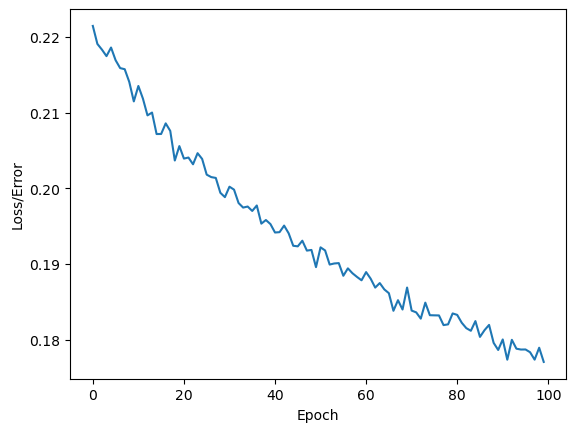

In [15]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')

### 2.2. Validation Test

In [16]:
epochs = 100
losses = []
for epoch in range(epochs):
    # Chuyển mô hình sang chế độ tập xác thực
    model.eval()

    # Xóa bộ nhớ cũ
    optimizer.zero_grad()

    # Dự đoán
    outputs = model(X_train_tensor)

    # Tính độ mất mát so với kết quả thực
    loss = loss_function(outputs, y_train_tensor)
    losses.append(loss.detach().cpu().numpy())

    # Dùng thuật toán Gradient Descent để cập nhật lại trọng số
    loss.backward()
    optimizer.step()

    # In kết quả
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.1753
Epoch [20/100], Loss: 0.1730
Epoch [30/100], Loss: 0.1722
Epoch [40/100], Loss: 0.1679
Epoch [50/100], Loss: 0.1649
Epoch [60/100], Loss: 0.1647
Epoch [70/100], Loss: 0.1638
Epoch [80/100], Loss: 0.1611
Epoch [90/100], Loss: 0.1594
Epoch [100/100], Loss: 0.1595


Text(0, 0.5, 'Loss/Error')

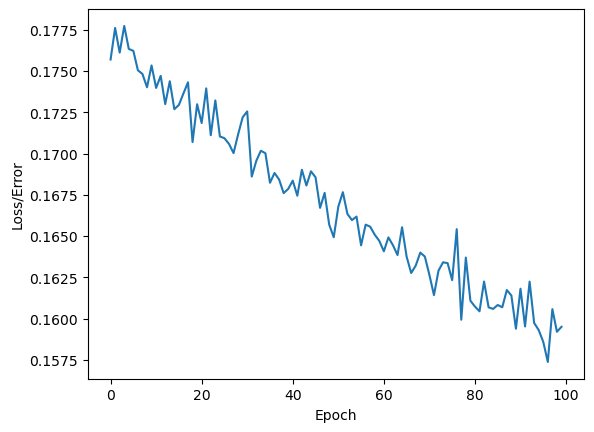

In [17]:
plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss/Error')